# Which restaurants do people talk about?

[Foursquare](http://foursquare.com/) has lots of restaurant reviews. But are all restaurants created equal? Or do people tend to talk more about one type of restaurant than another? Time for a closer look.

I decided to focus on the city of New York for a first analysis.

First, let's import some libraries that I'll need later.

In [70]:
import requests
import pandas as pd
import json
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Collect the data

### ZIP codes

I'm using an [official list of ZIP codes from NY state](https://data.ny.gov/Government-Finance/New-York-State-ZIP-Codes-County-FIPS-Cross-Referen/juva-r6g2) and am selecting the counties for the five boroughs.

In [2]:
all_ny_zip_codes = pd.read_csv('New_York_State_ZIP_Codes-County_FIPS_Cross-Reference.csv')
all_ny_zip_codes.head(1)

,County Name,State FIPS,County Code,County FIPS,ZIP Code,File Date
0,Albany,36,1,36001,12046,07/25/2007


In [3]:
zip_list = all_ny_zip_codes[all_ny_zip_codes['County Name'].isin(['New York', 'Bronx', 'Kings', 'Queens', 'Richmond'])]
zip_list['County Name'].value_counts()

New York    149
Queens       83
Kings        48
Bronx        30
Richmond     14
Name: County Name, dtype: int64

### Categories

Next, I need a list of categories for restaurants. The Foursquare API provides an [endpoint](https://developer.foursquare.com/docs/venues/categories) to just do that.

In [4]:
CLIENT_ID = ""
CLIENT_SECRET = ""
REDIRECT_URL = "http://localhost/"

In [5]:
url = f"https://api.foursquare.com/v2/venues/categories?client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&v=20170629&m=foursquare"
page = requests.get(url)
assert(page.ok)
page_j = page.json()
assert(page_j['meta']['code']==200)
categories = page_j['response']['categories']

The data is hierarchical, so I'll be building a category tree by storing the parent/child relationship.

In [6]:
cat_tree = {}

def check(c, parent, level):
    for cat in c:
        name = cat['name']
        id = cat['id']
        cat_tree[name] = (parent, level)
        if 'categories' in cat.keys():
            check(cat['categories'], name, level+1)
            
check(categories, 'TOP', 0)

### Find restaurants

Now let's get the restaurant data. I'll be doing one query for the category _food_ (`4d4b7105d754a06374d81259`) per zip code using the [search endpoint](https://developer.foursquare.com/docs/venues/search) and storing all results as a JSONL file.

**Note:** I have to specify a _radius_ around the zip code, otherwise Foursquare defaults to city-wide search and returns more or less the same venues for ech query.

**Note 2**: I'm randomizing the list of zip codes so that in case I run out of quota (1,000 queries/ 24hr), I still have something useful to work with.

In [55]:
CATEGORY = '4d4b7105d754a06374d81259'
for zip_code in tqdm(zip_list['ZIP Code'].sample(frac=1)):
    url = f"https://api.foursquare.com/v2/venues/search?near={zip_code:05d}&radius=1000&categoryId={CATEGORY}&client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&limit=50&v=20170629&m=foursquare"
    page = requests.get(url)
    if not page.ok:
        print(f'Error processing ZIP code {zip_code}.')
        print(page.content)
        continue
    page_j = page.json()
    assert(page_j['meta']['code']==200)
    venues = page_j['response']['venues']
    with open(f'venue_list_NYC.jsonl', 'a') as venue_file:
        for venue in venues:
            venue_file.write(json.dumps(venue)+"\n")

## Now some stats

Let's now use the collected data to gather the number of unique users, checkins and tips per venue. Also, we'll assign each venue to all top-level food categories that it belongs.

In [127]:
check_count = []
with open(f'venue_list_NYC.jsonl', 'r') as venue_file:
    for line in venue_file:
        venue = json.loads(line)
        for cat in venue['categories']:
            cat_name = cat['name']
            while True:
                (parent, level) = cat_tree[cat_name]
                if level <= 2: break
                cat_name = parent
            if level <= 1:
                cat_bucket = cat_name if parent == 'Food' else 'OUT'
            else:
                cat_bucket = parent if cat_tree[parent][0] == 'Food' else 'OUT'
            c = venue['stats']['checkinsCount']
            u = venue['stats']['usersCount']
            t = venue['stats']['tipCount']
            check_count.append([venue['id'], venue['name'], cat_name, cat_bucket, c, u, t])

In [66]:
df = pd.DataFrame(check_count, columns=['id', 'name', 'category', 'cat_bucket', 'checkinsCount', 'usersCount', 'tipCount'])
df.drop_duplicates(['id','cat_bucket'], inplace=True)
print(df.shape)
df.head(3)

(6648, 7)


,id,name,category,cat_bucket,checkinsCount,usersCount,tipCount
0,4ea97be39a522efffb9dc1bf,Boca Chica Seafood Restaurant,Seafood Restaurant,Seafood Restaurant,139,35,1
1,4cdfb01ff8a4a143c432e0bc,Chimi Truck @E174 St. & Jerome Ave,Food Truck,Food Truck,616,209,2
2,545cfc75498e15c9c461be33,Cafe Cosina,Coffee Shop,Coffee Shop,36,11,1


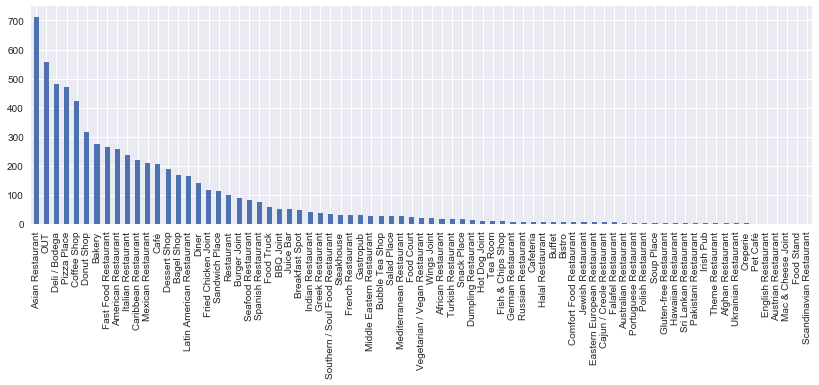

In [138]:
df.cat_bucket.value_counts().plot('bar', figsize=(14,4))

Interesting. While some categories are used frequently (*Asian Restaurant*, for example), others, like *Falafel Restaurant* show up very rarely. We're only seeing the **main category** so those more specific ones might appear more often as secondary categories.

The query below shows how the main category can be all over the place. Querying all categories of all 6,000+ restaurants in the dataset would exceed the API calls that I can place without putting my credit card number down.

In [153]:
df[df.name.str.contains('O\'|Pub')]

,id,name,category,cat_bucket,checkinsCount,usersCount,tipCount
159,4f0c74ede4b0f615a3725efd,Harlem Public,Bar,OUT,11461,4564,172
1657,4532a38ef964a520843b1fe3,Donovan's Pub,Pub,OUT,3212,1682,60
1910,54c595e2498e9ffb3d369250,Bushwick Public House,Coffee Shop,Coffee Shop,884,392,15
3838,50a14198e4b01718b433996f,Owl Juice Pub,Café,Café,1841,643,24
5669,544d3c7a498e300a738cd300,O'Neill's,Irish Pub,Irish Pub,289,102,1
6355,5667030a498ef28ad12dc4c5,Bagel Pub,Bagel Shop,Bagel Shop,2704,802,48
6506,4f900c3ee4b07368273ec967,Bagel Pub Park Slope,Bagel Shop,Bagel Shop,6448,1617,83
7107,50da5103e4b0f03130323026,Ly's Pub & Grill,Asian Restaurant,Asian Restaurant,4,4,1
7310,510193528302126a99141178,Putnam's Pub & Cooker,Pub,OUT,8714,3522,89
7314,4c848884d8086dcbd4608a52,Brooklyn Public House,Cocktail Bar,OUT,10864,4793,121


In [71]:
st=df[df.cat_bucket!='OUT'].groupby('cat_bucket').agg({
    'id': 'count',
    'checkinsCount': 'median',
    'usersCount': 'median',
    'tipCount': 'median',
})
st['checkinsPerUser'] = st.checkinsCount / st.usersCount
st['tipsPerUser'] = st.tipCount / st.usersCount
st.head(3)

,id,checkinsCount,usersCount,tipCount,checkinsPerUser,tipsPerUser
cat_bucket,,,,,,
Afghan Restaurant,2,343.0,193.5,10.0,1.772610,0.051680
African Restaurant,17,210.0,90.0,3.0,2.333333,0.033333
American Restaurant,256,1382.5,688.5,22.0,2.007988,0.031954


## Plot it

Now let's see which places in NYC people
- frequent regularly, measured by the number of checkins over the number of unique visitors
- have strong opinions about, measured by the number of tips over the number of unique visitors.

[]

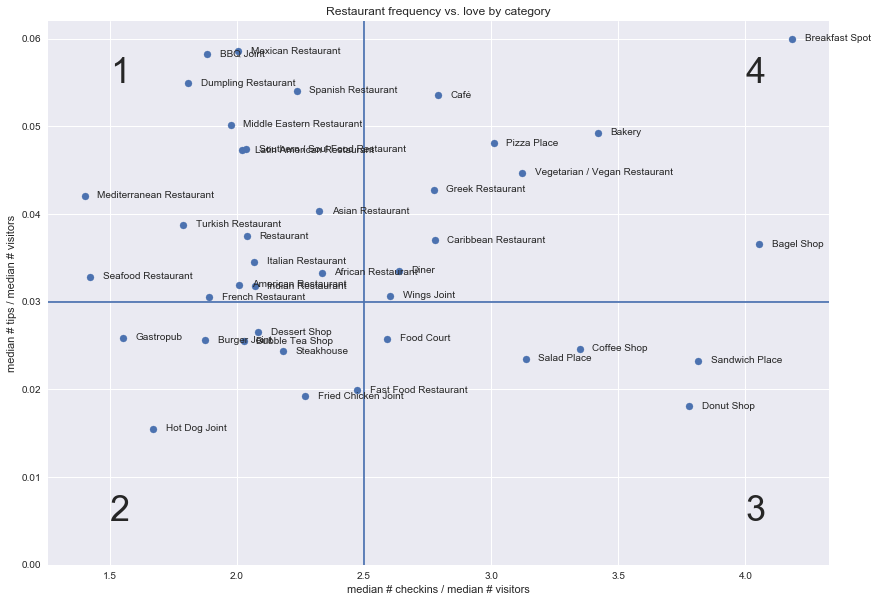

In [117]:
data = st[(st['id']>=10) & (st.usersCount>=50)]

plt.figure(figsize=(14,10))
plt.scatter(data.checkinsPerUser, data.tipsPerUser)

for dp in data.itertuples():
    xy = (dp.checkinsPerUser+0.05, dp.tipsPerUser)
    label = dp.Index
    plt.annotate(label,xy,verticalalignment='center')
    
plt.axhline(y=0.03)
plt.axvline(x=2.5)

plt.ylim(0,0.062)

plt.xlabel('median # checkins / median # visitors')
plt.ylabel('median # tips / median # visitors')
plt.title('Restaurant frequency vs. love by category')

plt.annotate('1', (1.5, 0.055), fontsize=36)
plt.annotate('2', (1.5, 0.005), fontsize=36)
plt.annotate('3', (4, 0.005), fontsize=36)
plt.annotate('4', (4, 0.055), fontsize=36)
    
plt.plot()

We can see four categories of restaurants (from top left, counter-clockwise):
1. **Foodie restaurants** where people only go occasionally, but leave lots of tips. These are usually more specialized ethnic restaurants.
2. **Indistinguishable Categories** where one is like the other, people usually don't go repeatedly to the same place, and also don't rave about it. *Hot Dog Joints* or *Bubble Tea Shops* fall into that category. I'd guess there are also a lot of impulse purchases here.
3. **Convenient basic food opportunities** where people go frequently but don't have strong feelings about it. It might be the *Food Court* next to your work, or the *Donut Shop* on the way home. Convenience trumps quality, they get the job done.
4. **Polarizers** where people frequent a venue a lot and leave many tips. While there are many *Breakfast Spots*, *Bagel Shops* or *Cafés*, it seems like people find the one that they really like and then visit it often and don't stop raving about it.

## Conclusion

Different restaurant categories typically cater to different use cases. It became evident that people don't necessarily visit often the places they love and vice versa. This offers different opportunities:
- Market *similar* other places to users who frequently visit the same places that they're not really passionate about (3).
- Market *different* places that foodies rave about to other foodies (1).

## Discussion

These are directional insights.
- The collected list of restaurants is not exhaustive (for example, a zip code could be more than 1000m in radius, or there could be over 50 restaurants in that radius).
- The analysis focuses only on tips and does not take price range as well as satisfaction rating into account.
- I only looked at the primary category for a restaurant, not at secondary categories.
- Some categories might be much less homogenous than others.